%reset

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from numpy.linalg import inv
import math
from dateutil.parser import parse
import matplotlib.pyplot as plt
from dateutil.parser import parse

In [18]:
df = pd.read_csv('./../input/train_1.csv', index_col=False, header=0)

In [19]:
signal_no = 5
signal = np.matrix(df.iloc[signal_no,1:].values)
ignorelen = 0                                     # Useful if you don't want to touch the testing data at all
 
if ignorelen == 0:
    u = signal[:]
else:
    u = signal[:-ignorelen]

_, length = signal.shape
siglen = length - ignorelen
logoffset = 10                # offset that is taken before taking log
dataoffset = 0               #                      after
                             # value 0: just an initialization
def inputmapping(x):
    temp= np.log(x + logoffset)
    global dataoffset
    dataoffset = -1 *  np.mean(temp)             # Tip: the offset is saved into dataoffset, to be used while inv. the log and shift
    return temp + dataoffset
    
    
def invinputmapping(x):                          # It undo the effect of inputmappint()
    return np.exp(x-dataoffset) - logoffset

def sine(period, length):
    x = np.array(length)
    y = np.sin(2 * np.pi * x / period)
    return y

datelist = np.array(list(df)[1:]).tolist()
dates = [parse(day).day for day in datelist]             # Dates needed to make sine signal of 1 month period

u = inputmapping(u.astype(float))
u = np.vstack((u,sine(10,range(550))))
u = np.vstack((u,sine(30,dates)))

__, u_len =  u.shape 

In [20]:
testlen = 30
pwin = 30
trainlen = u_len - testlen
# d = inputmapping( signal[0, pwin:trainlen].astype(float) ) 

def make_teachers():
    teachers = np.zeros((pwin,trainlen-pwin))
    for i in range(pwin):
        teachers[i,:] =  u[0, i+1:trainlen -(pwin)+i+1].astype(float)     # Assumption: u is already preprocessed (i.e logged and shifted) 
     
    return np.matrix(teachers)

d = make_teachers()

<IPython.core.display.Javascript object>


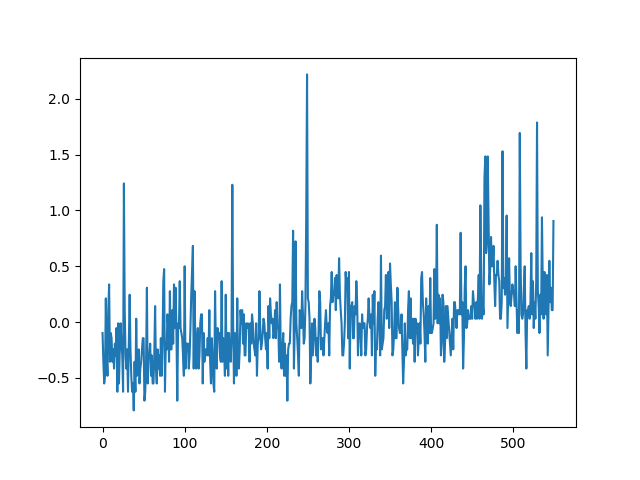

In [23]:
plt.plot(np.array(u)[0,:])
# plt.plot(np.array(u)[1,:])
# plt.plot(np.array(u)[2,:])

In [24]:
N = 100                                # Size of reservior

K, u_len =  u.shape                        # K: no of input signal
L,__     =  d.shape                        # L: no of output signal

np.random.seed(123)
W0    = np.random.rand(N,N) - 0.5       # The weights of synaptic links connecting the neurons
W_in0 = np.random.rand(N,K) - 0.5       # Weights for input links
                                        # The elements of W are in range of [-0.5, 0.5]
b0    = np.random.rand(N,1) - 0.5       # bias vector
W_fb0 = np.random.rand(N,L) - 0.5        # feedback weights matrix

eig_val, eig_vec = np.linalg.eig(W0)
W0 =  ( W0 / max(np.abs(eig_val)) )      # W with spectral radius of 1 unit

In [25]:
# Scaling factors
sf_W =   1                             # Scaling factor for W
sf_Win = 0.4                           # Scaling factor for W_in
sf_Wfb = 0.0000                          # zero for now
sf_b = 0                              # Scaling factor for bias
reg_coff = 0.000001                           # Regularization cofficient
alpha = 1                              # leaky intregator neuron coffecient

W_fb = sf_Wfb* W_fb0 
W = sf_W * W0
W_in = sf_Win * W_in0
b = sf_b * b0
#===========================================================================================#
x = np.zeros((N,1))                       # State Vector of ESN
x_t = np.zeros((N,1))

S = np.zeros((trainlen-pwin,N+K));             # Contains Extended Systems States filled row-wise
S = np.matrix(S)

for t in range(trainlen - pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b)
    x = (1-alpha) * x + alpha * x_t
    S[t,:] = np.vstack((x,u[:,t])).T
    
washout = 10
S_s = S[washout:,:]
d_s = d[:,washout:]

W_out =  np.dot(np.dot(d_s, S_s), inv( np.dot(S_s.T, S_s) + reg_coff * np.eye(N+K) ) )   #correct
#===========================================================================================#

Y = np.matrix(np.zeros((L,testlen)))
y = np.matrix(np.zeros((L,1)))
for t in range(trainlen-pwin,siglen-pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b  + np.dot(W_fb, y))
    x = (1-alpha) * x + alpha * x_t
    y = np.dot(W_out, np.vstack((x,u[:,t])) )
    Y[:,t-trainlen] = y
    
# print NRMSE(invinputmapping(u[0,-30:]),invinputmapping(Y))
# plt.plot( np.array(invinputmapping(u[0,-30:]))[0].tolist())

In [26]:
# num =0
# print NRMSE(np.array(invinputmapping(Y))[num],  np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0])
# # plt.plot( np.array(invinputmapping(Y))[num].tolist())
# # plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())

In [27]:
errSum = 0;
for i in range(pwin):
    errSum += NRMSE(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
print errSum/pwin   

1.32615538208


<IPython.core.display.Javascript object>


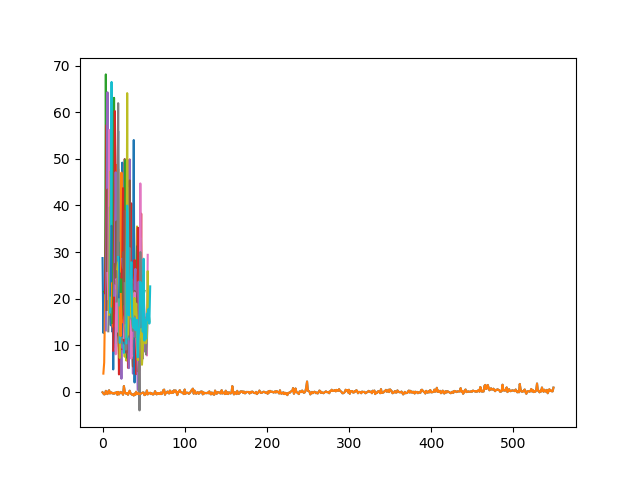

In [16]:
for i in range(pwin):
    plt.plot(range(i,i+pwin), np.array(invinputmapping(Y))[i].tolist())

In [13]:
plt.plot(df.iloc[signal_no,1:].values)

<IPython.core.display.Javascript object>


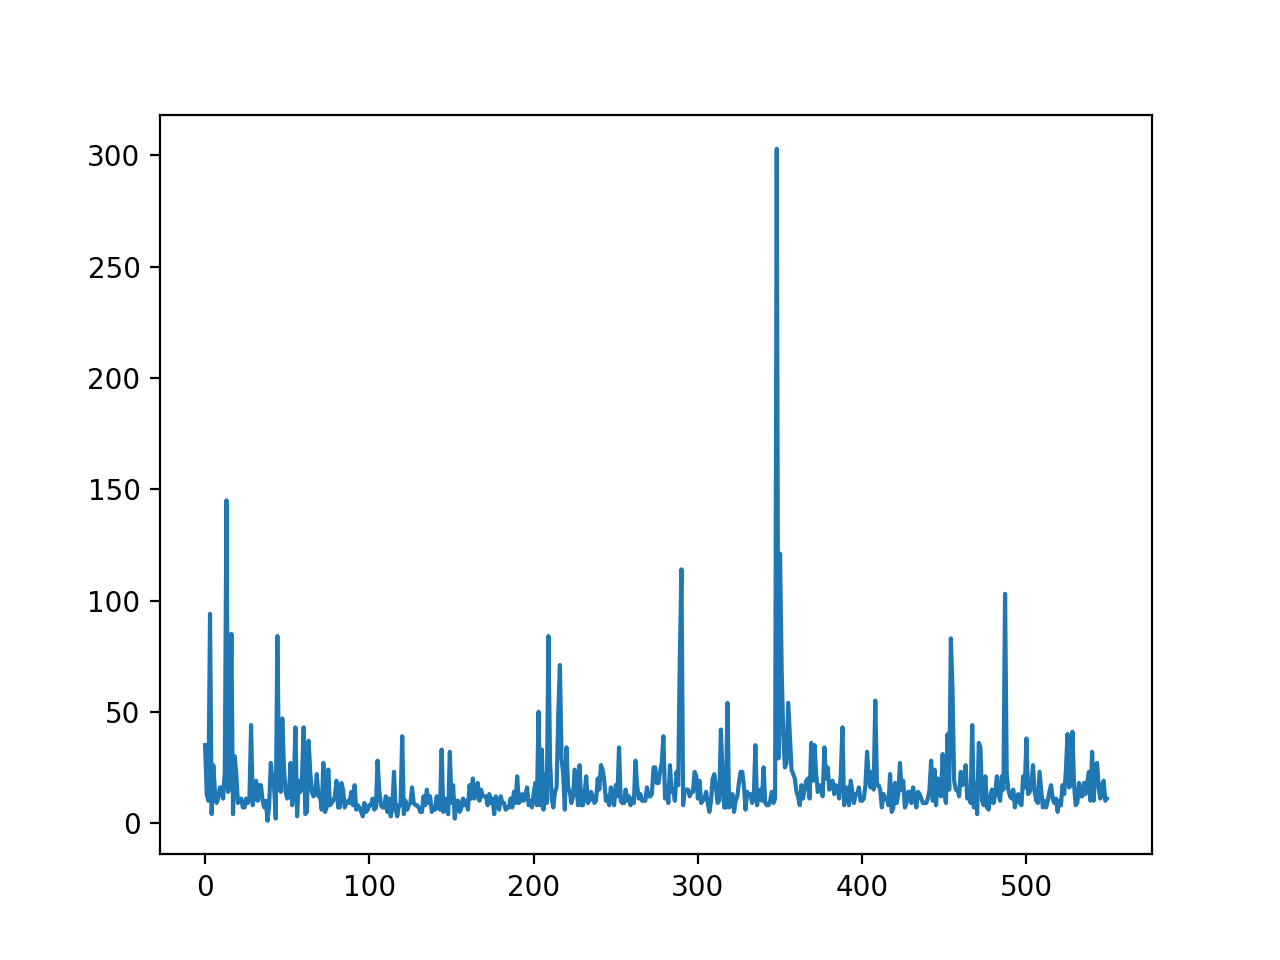

In [14]:
plt.plot(df.iloc[signal_no,1:].values)

In [9]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( d - np.mean(d) **2)
    NRMSE = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return NRMSE  

In [67]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    # for 1 dimensional d and p
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( np.power( (d  - np.mean(d)), 2) )
#     print 'var = ' ,var
    nrmse = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return nrmse

